# Insurance Loss Analytics

Author: Group 23



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import numpy as np
import pandas as pd
import os
import math
import statsmodels.api as sm
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
pd.set_option("display.max_columns", None)

from sklearn.metrics import r2_score, mean_squared_error

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
os.chdir('/content/drive/MyDrive/530 Project/data')
os.listdir()

## [1] Preprocessing

In [38]:
df = pd.read_csv("insurance_train.csv")

df["LC"] = np.where(df['X.16'] != 0, df['X.15']/df['X.16'], 0)
df["HALC"] = np.where(df['X.16'] != 0, (df['X.15']/df['X.16']) * df['X.18'], 0)
df["CS"] = np.where(df['X.16'] != 0, 1, 0)

column_rename_dict = {
    "X.1": "contract_id",
    "X.2": "contract_start_date",
    "X.3": "last_renewal_date",
    "X.4": "next_renewal_date",
    "X.5": "insured_birth_date",
    "X.6": "license_issue_date",
    "X.7": "contract_channel",
    "X.8": "years_with_company",
    "X.9": "total_policies",
    "X.10": "max_policies_held",
    "X.11": "max_products_held",
    "X.12": "policies_canceled_nonpayment",
    "X.13": "payment_method",
    "X.14": "net_premium",
    "X.15": "claims_cost_current_year",
    "X.16": "claims_count_current_year",
    "X.17": "claims_count_total",
    "X.18": "claims_per_year_ratio",
    "X.19": "vehicle_type",
    "X.20": "area_type",
    "X.21": "multiple_drivers_flag",
    "X.22": "vehicle_year",
    "X.23": "horsepower",
    "X.24": "cylinder_capacity",
    "X.25": "vehicle_value_2019",
    "X.26": "num_doors",
    "X.27": "fuel_type",
    "X.28": "vehicle_weight_kg"
}
df = df.rename(columns=column_rename_dict)

df['fuel_type'] = df['fuel_type'].fillna(df['fuel_type'].mode()[0])

date_columns = ['contract_start_date', 'last_renewal_date', 'next_renewal_date',
                'insured_birth_date', 'license_issue_date']

for col in date_columns:
    df[col] = pd.to_datetime(df[col], format='%d/%m/%Y', errors='coerce')

df['contract_age'] = (datetime.now() - df['contract_start_date']).dt.days / 365
df['age_of_insured'] = (datetime.now() - df['insured_birth_date']).dt.days / 365
df['license_age'] = (datetime.now() - df['license_issue_date']).dt.days / 365
df['time_to_next_renewal'] = (df['next_renewal_date'] - datetime.now()).dt.days / 365

vehicle_type_dummies = pd.get_dummies(df['vehicle_type'], prefix='vehicle_type')
fuel_type_dummies = pd.get_dummies(df['fuel_type'], prefix='fuel_type')

df = pd.concat([df, vehicle_type_dummies], axis=1)
df = pd.concat([df, fuel_type_dummies], axis=1)

df.drop(columns=date_columns + ['contract_id', 'vehicle_type', 'fuel_type',
                                'claims_cost_current_year','claims_count_current_year',
                                'claims_count_total', 'claims_per_year_ratio'], inplace=True)

In [39]:
# df.to_csv("train_preprocess_gk.csv")

## [3] Task 2: CS

In [40]:
X = df.drop(columns=["LC", "HALC", "CS"])
y_cs = df["CS"]
y_lc = df["LC"]
y_halc = df["HALC"]

# Unified split across all targets
X_train_CS, X_test_CS, y_train_CS, y_test_CS, y_LC_train, y_LC_test, y_HALC_train, y_HALC_test = train_test_split(
    X, y_cs, y_lc, y_halc,
    test_size=0.2,
    stratify=y_cs,
    random_state=42
)

In [41]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

xgb_model = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='auc',
    random_state=42,
    # scale_pos_weight=(len(y_train_CS[y_train_CS == 0]) / len(y_train_CS[y_train_CS == 1]))
)

param_grid = {
    "learning_rate": [0.01, 0.1],
    "n_estimators": [100, 200],
    "max_depth": [3, 5],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.5, 0.8]
}

grid = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train_CS, y_train_CS)


Fitting 3 folds for each of 32 candidates, totalling 96 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:05:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='auc', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.8],
                         'learning_rate': [0.01, 0.1], 'max_depth': [3, 5],
                         'n_estimators': [100, 200], 'subsample': [0.8, 1.0]},
             scoring='roc_auc', verbose=1)

In [42]:
from sklearn.metrics import roc_auc_score

# Best model from GridSearchCV
best_model = grid.best_estimator_

# Evaluate on final test set
test_probs = best_model.predict_proba(X_test_CS)[:, 1]
test_auc = roc_auc_score(y_test_CS, test_probs)
print("Test ROC-AUC:", test_auc)

# If you want classification threshold results too:
from sklearn.metrics import classification_report
print(classification_report(y_test_CS, best_model.predict(X_test_CS)))

Test ROC-AUC: 0.8493163767515642
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      6661
           1       0.62      0.17      0.26       830

    accuracy                           0.90      7491
   macro avg       0.76      0.58      0.60      7491
weighted avg       0.87      0.90      0.87      7491



##[2] TASK 1 model

In [43]:
X_train_lc_halc = X_train_CS[y_train_CS == 1]
y_LC_train_cs1 = y_LC_train[y_train_CS == 1]
y_HALC_train_cs1 = y_HALC_train[y_train_CS == 1]


In [44]:
#LC

import xgboost as xgb
from sklearn.model_selection import GridSearchCV


param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'subsample': [0.8],
    'colsample_bytree': [0.7],
    'reg_alpha': [0, 10],
    'reg_lambda': [1, 10]
}
# xg_reg = xgb.XGBRegressor(
#     objective='reg:tweedie',
#     tweedie_variance_power=1.5,  # fixed
#     random_state=42
# )
xg_reg = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42
)


grid_cv_lc = GridSearchCV(
    estimator=xg_reg,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

import time

start_time = time.time()
grid_cv_lc.fit(X_train_lc_halc, y_LC_train_cs1)
end_time = time.time()

print(f"GridSearchCV took {(end_time - start_time)/60:.2f} minutes")

# Output the best found hyperparameters and the best score
print("Best hyperparameters:", grid_cv_lc.best_params_)
print("Best cross-validation score (negative MSE):", grid_cv_lc.best_score_)


Fitting 3 folds for each of 48 candidates, totalling 144 fits
GridSearchCV took 0.53 minutes
Best hyperparameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 10, 'reg_lambda': 10, 'subsample': 0.8}
Best cross-validation score (negative MSE): -6648627.848680933


In [45]:
#HALC
import xgboost as xgb
from sklearn.model_selection import GridSearchCV


param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'subsample': [0.8],
    'colsample_bytree': [0.7],
    'reg_alpha': [0, 10],
    'reg_lambda': [1, 10]
}


xg_reg = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42
)

grid_cv_halc = GridSearchCV(
    estimator=xg_reg,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit GridSearchCV to the training data
import time

start_time = time.time()
grid_cv_halc.fit(X_train_lc_halc, y_HALC_train_cs1)
end_time = time.time()

print(f"GridSearchCV took {(end_time - start_time)/60:.2f} minutes")

# Output the best found hyperparameters and the best score
print("Best hyperparameters:", grid_cv_halc.best_params_)
print("Best cross-validation score (negative MSE):", grid_cv_halc.best_score_)


Fitting 3 folds for each of 48 candidates, totalling 144 fits
GridSearchCV took 0.50 minutes
Best hyperparameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 10, 'subsample': 0.8}
Best cross-validation score (negative MSE): -26881530.289080054


## [4] Use CS to predict LC and HALC

In [47]:
import math
def two_step_model(model_lc, model_halc, model_cs, cs_prob_threshold):
    # Predict CS (claim status)
    cs_probs = model_cs.predict_proba(X_test_CS)[:, 1]
    cs_preds = (cs_probs >= cs_prob_threshold).astype(int)

    # Initialize LC and HALC predictions as zeros
    lc_preds = np.zeros(len(X_test_CS))
    halc_preds = np.zeros(len(X_test_CS))

    # Indices where CS == 1
    cs_1_indices = np.where(cs_preds == 1)[0]

    # Apply LC & HALC models only to those
    lc_preds[cs_1_indices] = model_lc.predict(X_test_CS.iloc[cs_1_indices])
    halc_preds[cs_1_indices] = model_halc.predict(X_test_CS.iloc[cs_1_indices])

    final_preds = pd.DataFrame({
        "Predicted_CS": cs_preds,
        "Predicted_LC": lc_preds,
        "Predicted_HALC": halc_preds
    })

    # Calculate metrics
    LC_RMSE = math.sqrt(mean_squared_error(y_LC_test, final_preds["Predicted_LC"]))
    HALC_RMSE = math.sqrt(mean_squared_error(y_HALC_test, final_preds["Predicted_HALC"]))
    ROC_AUC = roc_auc_score(y_test_CS, cs_probs)

    return LC_RMSE, HALC_RMSE, ROC_AUC


In [48]:
from tqdm import tqdm
model_lc = grid_cv_lc.best_estimator_
model_halc = grid_cv_halc.best_estimator_

model_cs = grid.best_estimator_

out_dict = {}
for t in tqdm(np.arange(0.01, 0.99, 0.001)):
  LC_RMSE, HALC_RMSE, ROC_AUC = two_step_model(model_lc, model_halc, model_cs, t)

  out_dict[t] = [LC_RMSE, HALC_RMSE, ROC_AUC]

100%|██████████| 980/980 [01:05<00:00, 15.01it/s]


In [49]:
pd.DataFrame(out_dict)

,0.010,0.011,0.012,0.013,0.014,0.015,0.016,0.017,0.018,0.019,0.020,0.021,0.022,0.023,0.024,0.025,0.026,0.027,0.028,0.029,0.030,0.031,0.032,0.033,0.034,0.035,0.036,0.037,0.038,0.039,0.040,0.041,0.042,0.043,0.044,0.045,0.046,0.047,0.048,0.049,0.050,0.051,0.052,0.053,0.054,0.055,0.056,0.057,0.058,0.059,0.060,0.061,0.062,0.063,0.064,0.065,0.066,0.067,0.068,0.069,0.070,0.071,0.072,0.073,0.074,0.075,0.076,0.077,0.078,0.079,0.080,0.081,0.082,0.083,0.084,0.085,0.086,0.087,0.088,0.089,0.090,0.091,0.092,0.093,0.094,0.095,0.096,0.097,0.098,0.099,0.100,0.101,0.102,0.103,0.104,0.105,0.106,0.107,0.108,0.109,0.110,0.111,0.112,0.113,0.114,0.115,0.116,0.117,0.118,0.119,0.120,0.121,0.122,0.123,0.124,0.125,0.126,0.127,0.128,0.129,0.130,0.131,0.132,0.133,0.134,0.135,0.136,0.137,0.138,0.139,0.140,0.141,0.142,0.143,0.144,0.145,0.146,0.147,0.148,0.149,0.150,0.151,0.152,0.153,0.154,0.155,0.156,0.157,0.158,0.159,0.160,0.161,0.162,0.163,0.164,0.165,0.166,0.167,0.168,0.169,0.170,0.171,0.172,0.173,0.174,0.175,0.176,0.177,0.178,0.179,0.180,0.181,0.182,0.183,0.184,0.185,0.186,0.187,0.188,0.189,0.190,0.191,0.192,0.193,0.194,0.195,0.196,0.197,0.198,0.199,0.200,0.201,0.202,0.203,0.204,0.205,0.206,0.207,0.208,0.209,0.210,0.211,0.212,0.213,0.214,0.215,0.216,0.217,0.218,0.219,0.220,0.221,0.222,0.223,0.224,0.225,0.226,0.227,0.228,0.229,0.230,0.231,0.232,0.233,0.234,0.235,0.236,0.237,0.238,0.239,0.240,0.241,0.242,0.243,0.244,0.245,0.246,0.247,0.248,0.249,0.250,0.251,0.252,0.253,0.254,0.255,0.256,0.257,0.258,0.259,0.260,0.261,0.262,0.263,0.264,0.265,0.266,0.267,0.268,0.269,0.270,0.271,0.272,0.273,0.274,0.275,0.276,0.277,0.278,0.279,0.280,0.281,0.282,0.283,0.284,0.285,0.286,0.287,0.288,0.289,0.290,0.291,0.292,0.293,0.294,0.295,0.296,0.297,0.298,0.299,0.300,0.301,0.302,0.303,0.304,0.305,0.306,0.307,0.308,0.309,0.310,0.311,0.312,0.313,0.314,0.315,0.316,0.317,0.318,0.319,0.320,0.321,0.322,0.323,0.324,0.325,0.326,0.327,0.328,0.329,0.330,0.331,0.332,0.333,0.334,0.335,0.336,0.337,0.338,0.339,0.340,0.341,0.342,0.343,0.344,0.345,0.346,0.347,0.348,0.349,0.350,0.351,0.352,0.353,0.354,0.355,0.356,0.357,0.358,0.359,0.360,0.361,0.362,0.363,0.364,0.365,0.366,0.367,0.368,0.369,0.370,0.371,0.372,0.373,0.374,0.375,0.376,0.377,0.378,0.379,0.380,0.381,0.382,0.383,0.384,0.385,0.386,0.387,0.388,0.389,0.390,0.391,0.392,0.393,0.394,0.395,0.396,0.397,0.398,0.399,0.400,0.401,0.402,0.403,0.404,0.405,0.406,0.407,0.408,0.409,0.410,0.411,0.412,0.413,0.414,0.415,0.416,0.417,0.418,0.419,0.420,0.421,0.422,0.423,0.424,0.425,0.426,0.427,0.428,0.429,0.430,0.431,0.432,0.433,0.434,0.435,0.436,0.437,0.438,0.439,0.440,0.441,0.442,0.443,0.444,0.445,0.446,0.447,0.448,0.449,0.450,0.451,0.452,0.453,0.454,0.455,0.456,0.457,0.458,0.459,0.460,0.461,0.462,0.463,0.464,0.465,0.466,0.467,0.468,0.469,0.470,0.471,0.472,0.473,0.474,0.475,0.476,0.477,0.478,0.479,0.480,0.481,0.482,0.483,0.484,0.485,0.486,0.487,0.488,0.489,0.490,0.491,0.492,0.493,0.494,0.495,0.496,0.497,0.498,0.499,0.500,0.501,0.502,0.503,0.504,0.505,0.506,0.507,0.508,0.509,0.510,0.511,0.512,0.513,0.514,0.515,0.516,0.517,0.518,0.519,0.520,0.521,0.522,0.523,0.524,0.525,0.526,0.527,0.528,0.529,0.530,0.531,0.532,0.533,0.534,0.535,0.536,0.537,0.538,0.539,0.540,0.541,0.542,0.543,0.544,0.545,0.546,0.547,0.548,0.549,0.550,0.551,0.552,0.553,0.554,0.555,0.556,0.557,0.558,0.559,0.560,0.561,0.562,0.563,0.564,0.565,0.566,0.567,0.568,0.569,0.570,0.571,0.572,0.573,0.574,0.575,0.576,0.577,0.578,0.579,0.580,0.581,0.582,0.583,0.584,0.585,0.586,0.587,0.588,0.589,0.590,0.591,0.592,0.593,0.594,0.595,0.596,0.597,0.598,0.599,0.600,0.601,0.602,0.603,0.604,0.605,0.606,0.607,0.608,0.609,0.610,0.611,0.612,0.613,0.614,0.615,0.616,0.617,0.618,0.619,0.620,0.621,0.622,0.623,0.624,0.625,0.626,0.627,0.628,0.629,0.630,0.631,0.632,0.633,0.634,0.635,0.636,0.637,0.638,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648,0.649,0.650,0.651,0.652,0.653,0.654,0.655,0.656,0.657,0.658,0.659,0.660,0.661,0.662,0.663,0.664,0.665,0.666,0.667,0.668,0.669,0.670,0.671,0.672,0.673,0.674,0.675,0.6

In [50]:
# Convert the dictionary to a DataFrame for easier manipulation
df_out_dict = pd.DataFrame(out_dict).T.reset_index()
df_out_dict.columns = ['threshold', 'LC_RMSE', 'HALC_RMSE', 'ROC_AUC']


# Find the keys (thresholds) corresponding to the lowest LC_RMSE and HALC_RMSE
lowest_LC_RMSE_key = df_out_dict.loc[df_out_dict['LC_RMSE'].idxmin(), 'threshold']
lowest_HALC_RMSE_key = df_out_dict.loc[df_out_dict['HALC_RMSE'].idxmin(), 'threshold']

print(f"Threshold for lowest LC_RMSE: {lowest_LC_RMSE_key}")
print(f"Threshold for lowest HALC_RMSE: {lowest_HALC_RMSE_key}")


Threshold for lowest LC_RMSE: 0.5079999999999996
Threshold for lowest HALC_RMSE: 0.5079999999999996


In [70]:
print("Best RMSE for LC: ", out_dict[lowest_LC_RMSE_key][0])

Best RMSE for LC:  640.8708297279916


In [71]:
print("Best RMSE for HALC: ", out_dict[lowest_HALC_RMSE_key][1])

Best RMSE for HALC:  1172.5550081529175


##Results

## FINAL Prediction

In [ ]:
df_test = pd.read_csv('insurance_test.csv')
df_test.head()

,X.2,X.3,X.4,X.5,X.6,X.7,X.8,X.9,X.10,X.11,X.12,X.13,X.14,X.19,X.20,X.21,X.22,X.23,X.24,X.25,X.26,X.27,X.28
0,23/06/2017,23/06/2018,23/06/2019,13/09/1982,03/02/2011,0,2,2,2,1,1,0,240.76,3,1,0,2003,115,1910,16400.00,5,D,1305
1,29/06/2015,29/06/2016,29/06/2017,07/07/1946,12/08/1966,0,2,1,1,1,1,1,367.97,3,0,0,1999,90,1597,13480.70,5,P,1083
2,14/03/2018,14/03/2018,14/03/2019,26/12/1957,02/09/1977,0,1,4,4,2,0,0,291.90,3,0,0,2003,143,2148,36500.00,5,D,1495
3,16/10/2014,16/10/2018,16/10/2019,27/02/1961,29/10/1980,1,5,1,1,1,0,0,303.28,2,1,0,1998,60,1686,12356.81,5,D,1010
4,01/07/2015,01/07/2017,01/07/2018,03/07/1986,02/08/2006,0,3,1,1,1,1,0,333.30,3,0,0,2015,66,998,11800.00,5,P,933


In [ ]:
df_test.shape

(15787, 23)

In [ ]:

column_rename_dict = {
    "X.1": "contract_id",
    "X.2": "contract_start_date",
    "X.3": "last_renewal_date",
    "X.4": "next_renewal_date",
    "X.5": "insured_birth_date",
    "X.6": "license_issue_date",
    "X.7": "contract_channel",
    "X.8": "years_with_company",
    "X.9": "total_policies",
    "X.10": "max_policies_held",
    "X.11": "max_products_held",
    "X.12": "policies_canceled_nonpayment",
    "X.13": "payment_method",
    "X.14": "net_premium",
    "X.15": "claims_cost_current_year",
    "X.16": "claims_count_current_year",
    "X.17": "claims_count_total",
    "X.18": "claims_per_year_ratio",
    "X.19": "vehicle_type",
    "X.20": "area_type",
    "X.21": "multiple_drivers_flag",
    "X.22": "vehicle_year",
    "X.23": "horsepower",
    "X.24": "cylinder_capacity",
    "X.25": "vehicle_value_2019",
    "X.26": "num_doors",
    "X.27": "fuel_type",
    "X.28": "vehicle_weight_kg"
}
df_test = df_test.rename(columns=column_rename_dict)

In [ ]:
df_test['fuel_type'] = df_test['fuel_type'].fillna(df_test['fuel_type'].mode()[0])

date_columns = ['contract_start_date', 'last_renewal_date', 'next_renewal_date',
                'insured_birth_date', 'license_issue_date']

for col in date_columns:
    df_test[col] = pd.to_datetime(df_test[col], format='%d/%m/%Y', errors='coerce')

df_test['contract_age'] = (datetime.now() - df_test['contract_start_date']).dt.days / 365
df_test['age_of_insured'] = (datetime.now() - df_test['insured_birth_date']).dt.days / 365
df_test['license_age'] = (datetime.now() - df_test['license_issue_date']).dt.days / 365
df_test['time_to_next_renewal'] = (df_test['next_renewal_date'] - datetime.now()).dt.days / 365

vehicle_type_dummies = pd.get_dummies(df_test['vehicle_type'], prefix='vehicle_type')
fuel_type_dummies = pd.get_dummies(df_test['fuel_type'], prefix='fuel_type')

df_test = pd.concat([df_test, vehicle_type_dummies], axis=1)
df_test = pd.concat([df_test, fuel_type_dummies], axis=1)

df_test.drop(columns=date_columns + [ 'vehicle_type', 'fuel_type'], inplace=True)

In [ ]:
cs_probs = model_cs.predict_proba(df_test)[:, 1]
cs_preds_lc = (cs_probs >= lowest_LC_RMSE_key).astype(int)
cs_preds_halc = (cs_probs >= lowest_HALC_RMSE_key).astype(int)

# Initialize LC and HALC predictions as zeros
lc_preds = np.zeros(len(df_test))
halc_preds = np.zeros(len(df_test))

# Indices where CS == 1
cs_1_indices_lc = np.where(cs_preds_lc == 1)[0]
cs_1_indices_halc = np.where(cs_preds_halc == 1)[0]

# Apply LC & HALC models only to those
lc_preds[cs_1_indices_lc] = model_lc.predict(df_test.iloc[cs_1_indices_lc])
halc_preds[cs_1_indices_halc] = model_halc.predict(df_test.iloc[cs_1_indices_halc])

In [ ]:
FINAL_OUT = pd.DataFrame({"LC": lc_preds, "HALC": halc_preds, 'CS': cs_probs})
FINAL_OUT.head()

,LC,HALC,CS
0,0.0,0.0,0.318538
1,0.0,0.0,0.349784
2,0.0,0.0,0.808739
3,0.0,0.0,0.117659
4,0.0,0.0,0.074380


In [ ]:
FINAL_OUT.shape

(15787, 3)

In [ ]:
FINAL_OUT.to_csv("group_23_prediction.csv")

In [ ]:
FINAL_OUT.describe()

,LC,HALC,CS
count,15787.000000,15787.000000,15787.000000
mean,27.999129,52.522800,0.364225
std,135.046940,254.775644,0.260443
min,0.000000,0.000000,0.002646
25%,0.000000,0.000000,0.133333
50%,0.000000,0.000000,0.314966
75%,0.000000,0.000000,0.570261
max,2354.228516,6027.395996,0.968935


In [ ]:
df[['LC', 'HALC', 'CS']].describe()

,LC,HALC,CS
count,37451.000000,37451.000000,37451.000000
mean,69.810230,128.147849,0.110838
std,838.664672,1665.727208,0.313936
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,118142.590000,236285.180000,1.000000


In [ ]:
df[df['CS'] == 0][['LC', 'HALC', 'CS']].describe()

,LC,HALC,CS
count,33300.0,33300.0,33300.0
mean,0.0,0.0,0.0
std,0.0,0.0,0.0
min,0.0,0.0,0.0
25%,0.0,0.0,0.0
50%,0.0,0.0,0.0
75%,0.0,0.0,0.0
max,0.0,0.0,0.0


In [ ]:
print(f"Number of rows:&nbsp;{len(FINAL_OUT)}")
print(f"Number of columns:&nbsp;{len(FINAL_OUT.columns)}")
print(f"Column names:&nbsp;{list(FINAL_OUT.columns)}")
print(FINAL_OUT.dtypes)

Number of rows:&nbsp;15787
Number of columns:&nbsp;3
Column names:&nbsp;['LC', 'HALC', 'CS']
LC      float64
HALC    float64
CS      float32
dtype: object


##  [5] SHAP

 99%|===================| 29516/29960 [00:49<00:00]       

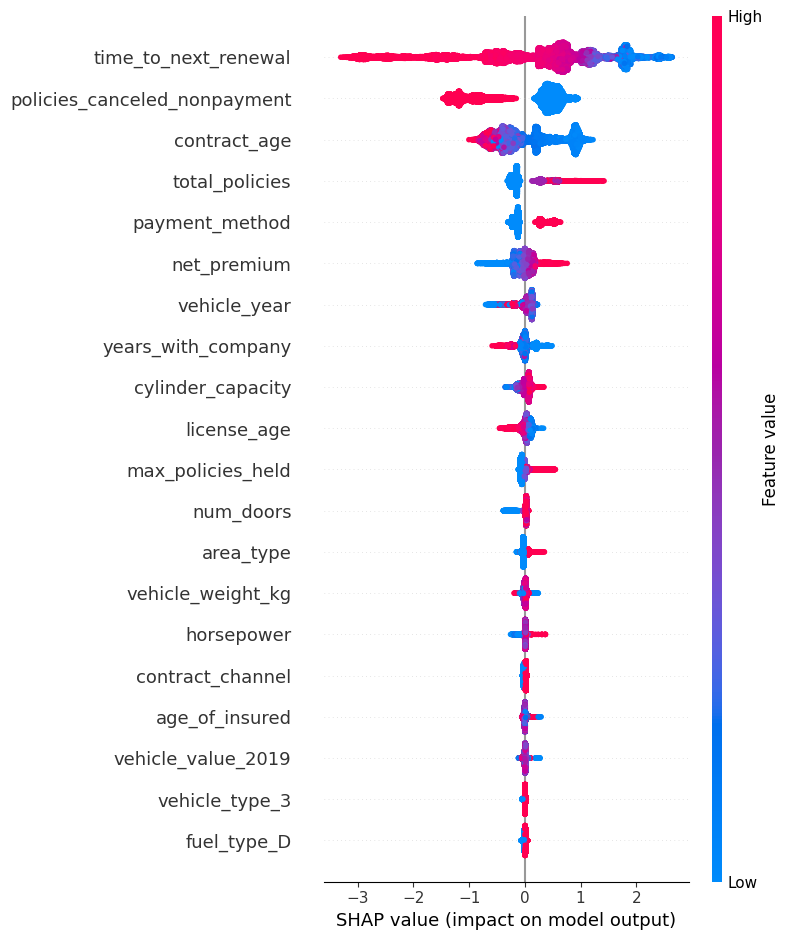

In [32]:
import shap
X_train_CS = X_train_CS.astype(float)

explainer_cs = shap.Explainer(model_cs, X_train_CS)
shap_values_cs = explainer_cs(X_train_CS)

# Global feature impact (summary plot)
shap.summary_plot(shap_values_cs, X_train_CS)


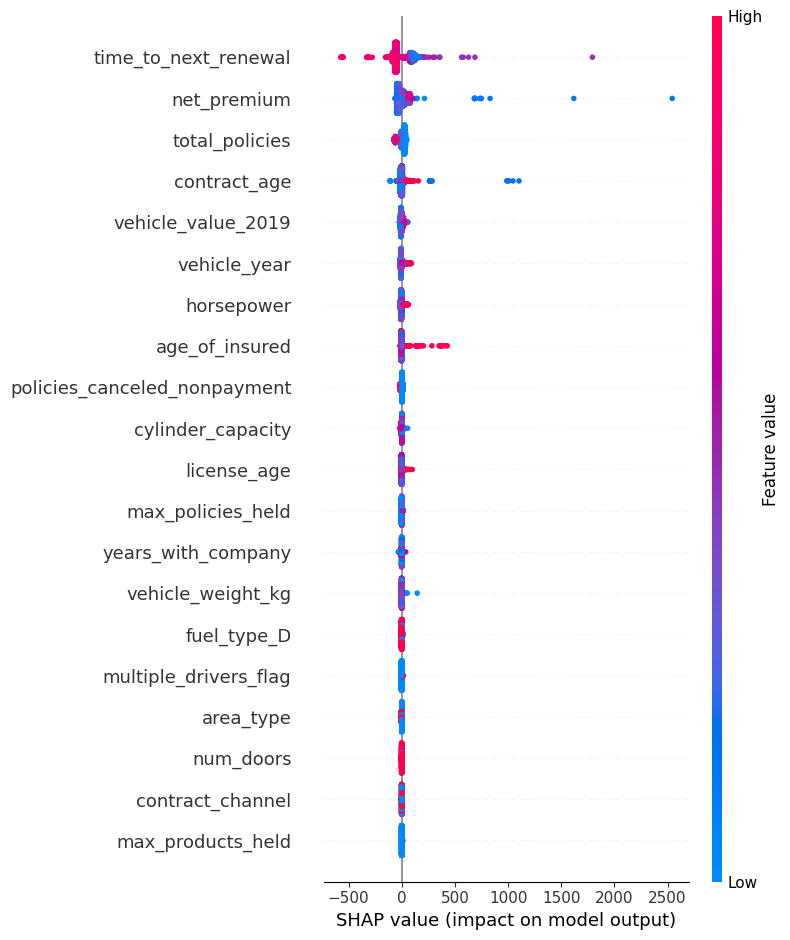

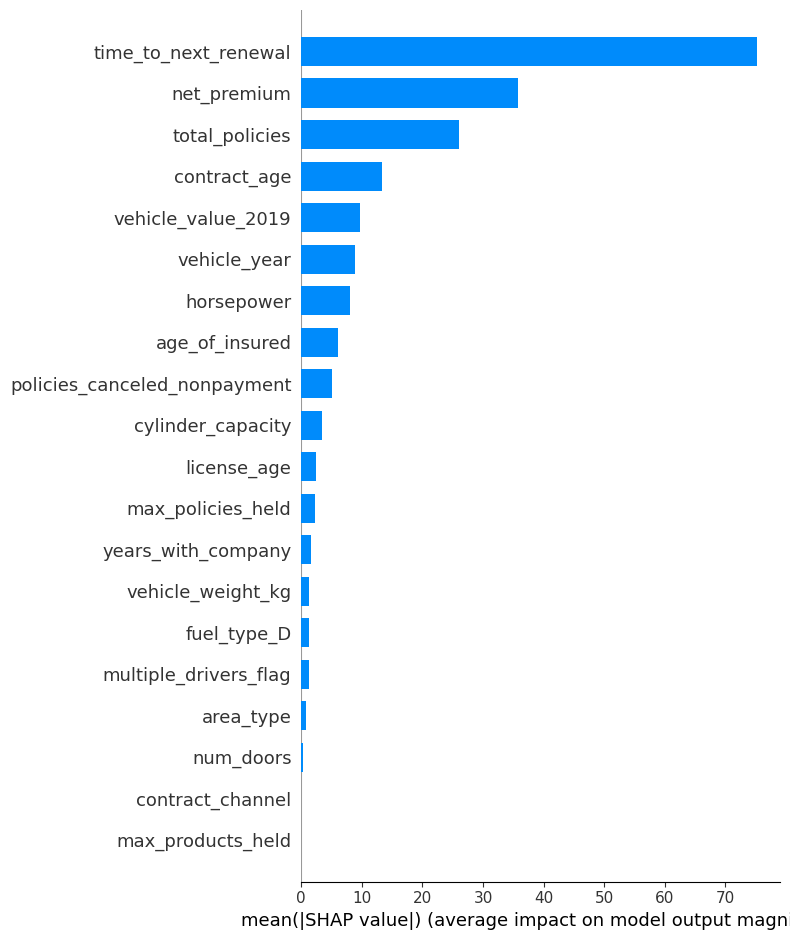

In [33]:
X_train_lc_halc = X_train_lc_halc.astype(float)

explainer_lc = shap.Explainer(model_lc, X_train_lc_halc)
shap_values_lc = explainer_lc(X_train_lc_halc)

shap.summary_plot(shap_values_lc, X_train_lc_halc)
shap.summary_plot(shap_values_lc, X_train_lc_halc, plot_type="bar")

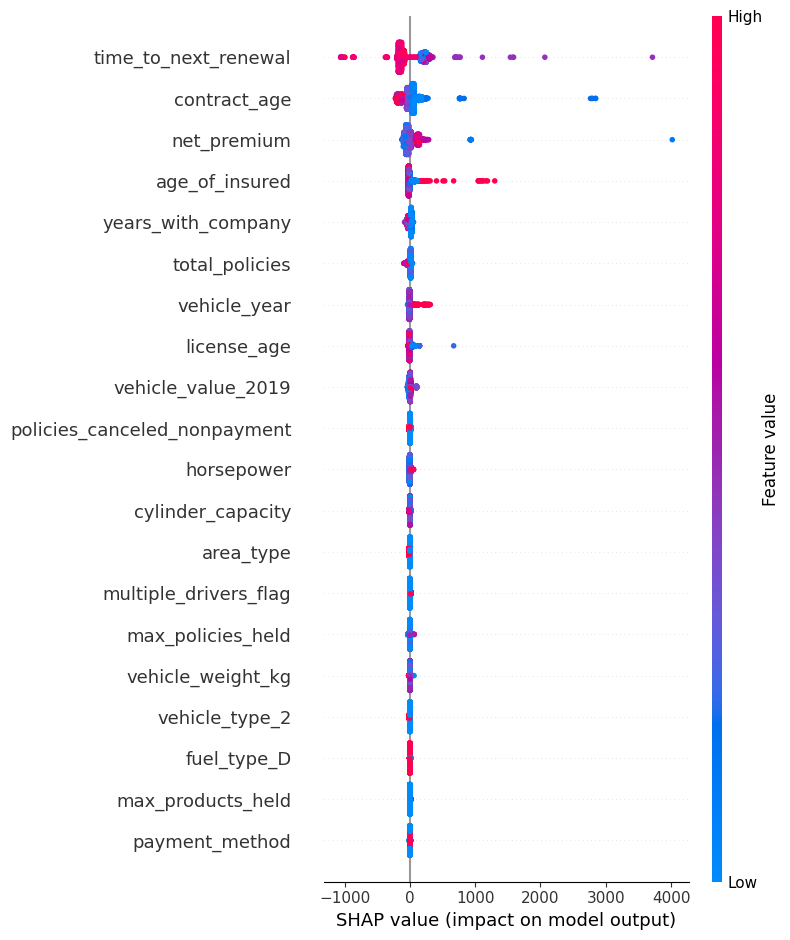

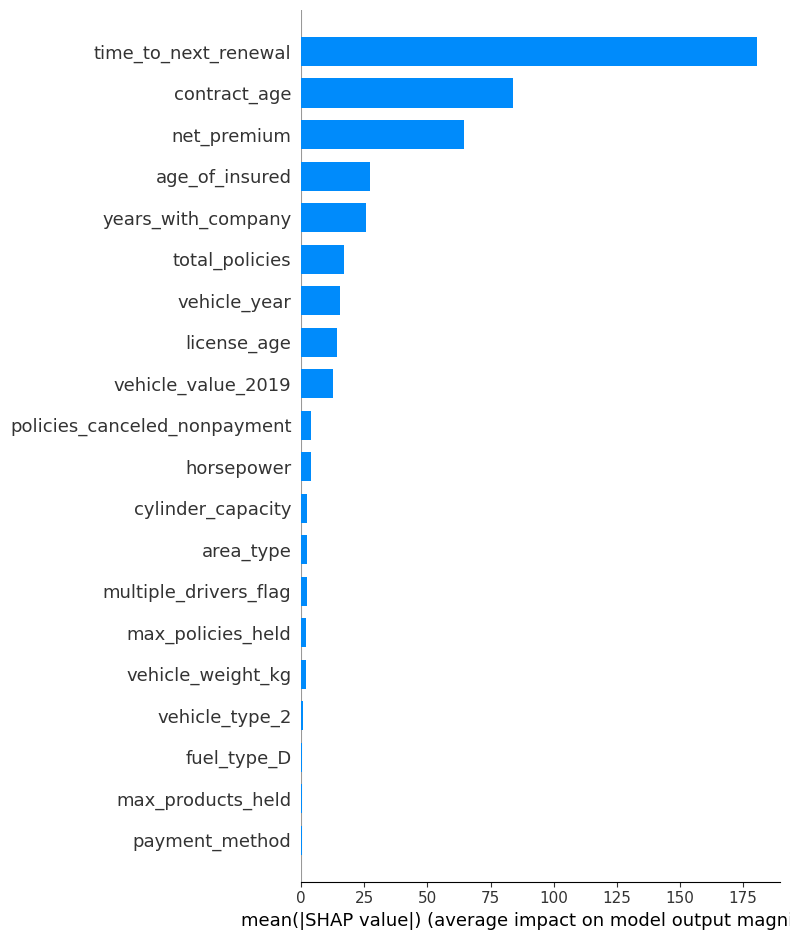

In [34]:
explainer_halc = shap.Explainer(model_halc, X_train_lc_halc)
shap_values_halc = explainer_halc(X_train_lc_halc)

shap.summary_plot(shap_values_halc, X_train_lc_halc)
shap.summary_plot(shap_values_halc, X_train_lc_halc, plot_type="bar")
